### Call the env

In [1]:
import numpy as np
import gym
from gym import spaces
from environments.env import InverterControlEnv
from environments.env_registration import register_env

register_env(
    env_id='InverterControl-v0',  # Unique environment ID
    entry_point='environments.env_registration:environment_creator',  # Path to environment_creator function
    kwargs={'environment_class': InverterControlEnv}  # Pass the environment class and additional parameters
)

# Create an instance of the environment
env = InverterControlEnv()


### test the env

In [2]:
# Test the environment
state = env.reset()
for _ in range(10):
    action = env.action_space.sample()  # Random action
    next_state, reward, done, _ = env.step(action)
    env.render()
    print(f"Reward: {reward}")
    if done:
        break

State: [0.12576826 4.1651016 ]
Reward: -1.6621299283969564
State: [0.1492284  4.16432706]
Reward: -0.7908891049113436
State: [0.13362202 4.16485704]
Reward: -0.871652362178218
State: [0.08942814 4.16604028]
Reward: -2.0767395935919315
State: [0.1544833  4.16413543]
Reward: -0.6697746512220456
State: [0.18616038 4.16283957]
Reward: -0.27630083969803715
State: [0.22204532 4.16107977]
Reward: -0.3343691571934698
State: [0.10672577 4.16563304]
Reward: -1.3422003026275942
State: [0.19864988 4.16226227]
Reward: -0.38539854500771176
State: [0.33498385 4.15351355]
Reward: -0.2754152748402026


In [3]:
import gym
print(gym.__version__)


0.12.1


### testing ppo

In [4]:
# load expert_occupancy_measure.pkl
import pickle
with open('expert_occupancy_measure.pkl', 'rb') as f:
    expert_occupancy_measure = pickle.load(f)[0]


In [5]:
from learning_utils.occupancy_estimator import StateActionOccupancyEstimator

estimator = StateActionOccupancyEstimator()
estimator.print_occupancy_measure(expert_occupancy_measure)


# need to find percentage of elements that are non-zero
def get_occupancy_measure(occupancy_measure):
    num_non_zero = np.count_nonzero(occupancy_measure)
    total_elements = occupancy_measure.size
    print(num_non_zero)
    return num_non_zero / total_elements

# test
print(get_occupancy_measure(expert_occupancy_measure))


State-Action Occupancy Measure
State Bins: 3, Action Bins: 3

State (s0, s1)                 | Actions (u0, u1)               | Occupancy      
--------------------------------------------------------------------------------
(0.00, 0.00)                   | 0.0004                         | 0.0004         
(0.00, 2.78)                   | 0.0014, 0.0168, 0.0006         | 0.0189         
(2.78, -2.78)                  | 0.0004, 0.0008, 0.0002         | 0.0014         
(2.78, 0.00)                   | 0.0008, 0.0187, 0.0004, 0.0002 | 0.0201         
(2.78, 2.78)                   | 0.0018, 0.0014, 0.0023, 0.0002, 0.0002 | 0.0060         
--------------------------------------------------------------------------------
Note: Probabilities are shown only for actions with non-zero occupancy.

181
0.0181


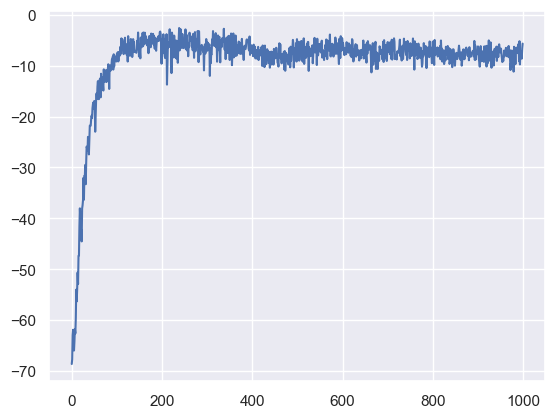

In [ ]:
from rl_monitoring_utils.vectorized_env_wrapper import VectorizedEnvWrapper
from policies.diagonal_gaussian import DiagonalGaussianPolicy
from policies.categorical_policy import CategoricalPolicy
from learning_utils.value_estimator import ValueEstimator
from agents.ppo import PPO
import gym


# energy_management = VectorizedEnvWrapper(gym.make("EnergyManagement-v0"), num_envs=8)
inverter_control = VectorizedEnvWrapper(gym.make("InverterControl-v0"), num_envs=8)

# policy = CategoricalPolicy(inverter_control, lr = 1e-2)
policy = DiagonalGaussianPolicy(inverter_control, lr = 1e-2, hidden_sizes=[64, 32])
value_estimator = ValueEstimator(inverter_control, lr=1e-2)
ppo_agent, totals_ppo_1 = PPO(inverter_control, policy, value_estimator, epochs=1000, gamma = 1, T = 100, kl_threshold=1e-3, expert_occupancy_measure=expert_occupancy_measure, c = 100)

### evaluate the performance

In [7]:
class PropController():
    def __init__(self):
        # self.K = np.array([[0.608, 0.027],[0.012, 0.026]])
        self.K = np.array([[1.206, 0.0957],[0.096, 0.0671]])
    def act(self, state):
        return np.array([np.dot(self.K, state[0])]), None

In [8]:
inverter_control_evaluate = VectorizedEnvWrapper(gym.make("InverterControl-v0"), num_envs=1)


In [9]:
all_costs = []
T=100
num_runs = 1000
agent = ppo_agent

initial_states = []

for run in range(num_runs):
    # for learning
    states = np.empty((T, 1, inverter_control_evaluate.observation_space.shape[0]))
    if isinstance(inverter_control_evaluate.action_space, gym.spaces.Discrete):
        # discrete action spaces only need to store a
        # scalar for each action.
        actions = np.empty((T, 1))
    else:
        # continuous action spaces need to store a
        # vector for each action.
        actions = np.empty((T, 1, inverter_control_evaluate.action_space.shape[0]))
    rewards = np.empty((T, 1))
    dones = np.empty((T, 1))

    s_t = inverter_control_evaluate.reset()
    initial_states.append(s_t)

    for t in range(T):
        # Organized inverse sin/cos information
        # print(f"Run {run+1}, Step {t+1}")
        # print(f"Month (inverse sin): {np.arcsin(s_t[3])}, Month (inverse cos): {np.arccos(s_t[4])}")
        # print(f"Day (inverse sin): {np.arcsin(s_t[5])}, Day (inverse cos): {np.arccos(s_t[6])}")

        a_t, _ = agent.act(s_t)
        s_t_next, r_t, d_t = inverter_control_evaluate.step(a_t)

        # for learning
        states[t] = s_t
        actions[t] = a_t
        rewards[t] = r_t
        dones[t] = d_t

        s_t = s_t_next

    cost = rewards.sum() 
    all_costs.append(cost)
print(sum(all_costs)/num_runs)

-7.308140945692359


In [10]:
all_costs = []
T=100
num_runs = 1000
prop_controller = PropController()
agent = prop_controller

for run in range(num_runs):
    # for learning
    states = np.empty((T, 1, inverter_control_evaluate.observation_space.shape[0]))
    if isinstance(inverter_control_evaluate.action_space, gym.spaces.Discrete):
        # discrete action spaces only need to store a
        # scalar for each action.
        actions = np.empty((T, 1))
    else:
        # continuous action spaces need to store a
        # vector for each action.
        actions = np.empty((T, 1, inverter_control_evaluate.action_space.shape[0]))
    rewards = np.empty((T, 1))
    dones = np.empty((T, 1))

    s_t = inverter_control_evaluate.reset()

    for t in range(T):
        # Organized inverse sin/cos information
        # print(f"Run {run+1}, Step {t+1}")
        # print(f"Month (inverse sin): {np.arcsin(s_t[3])}, Month (inverse cos): {np.arccos(s_t[4])}")
        # print(f"Day (inverse sin): {np.arcsin(s_t[5])}, Day (inverse cos): {np.arccos(s_t[6])}")

        a_t, _ = agent.act(s_t)
        s_t_next, r_t, d_t = inverter_control_evaluate.step(a_t)

        # for learning
        states[t] = s_t
        actions[t] = a_t
        rewards[t] = r_t
        dones[t] = d_t

        s_t = s_t_next

    cost = rewards.sum() 
    all_costs.append(cost)
print(sum(all_costs)/num_runs)

-7.346870489784188


### confidence intervals

C:\Users\mf36244\AppData\Local\Temp\ipykernel_31008\627432374.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_melted_1, x='Epoch', y='Reward', ci="sd", estimator="mean")


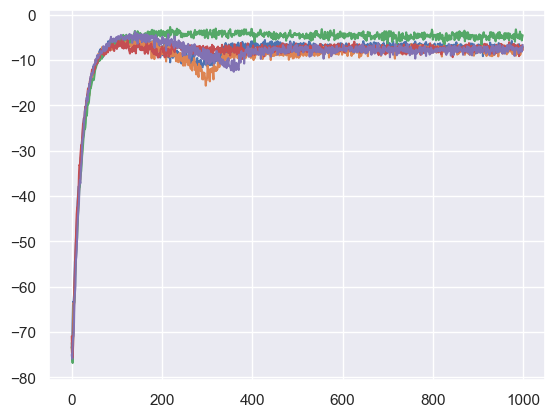

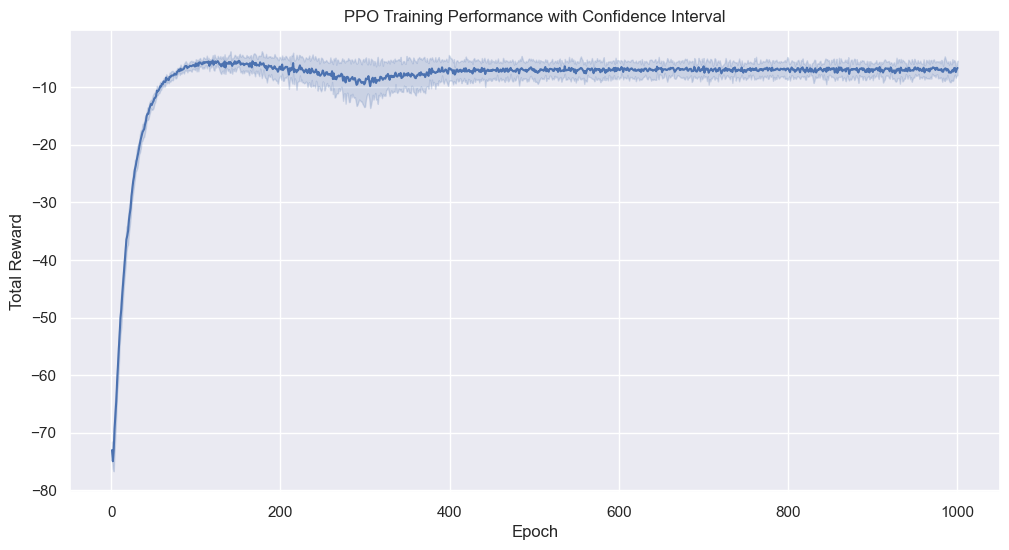

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rl_monitoring_utils.vectorized_env_wrapper import VectorizedEnvWrapper
from policies.diagonal_gaussian import DiagonalGaussianPolicy
from learning_utils.value_estimator import ValueEstimator
from agents.ppo import PPO
import gym

# Initialize environment and models
inverter_control = VectorizedEnvWrapper(gym.make("InverterControl-v0"), num_envs=8)

# Parameters
num_repeats = 5
epochs = 1000
gamma = 1
T = 720
kl_threshold = 1e-3

# Store total rewards for each run
all_rewards = []

for run in range(num_repeats):
    # Initialize new instances for each run
    # policy = CategoricalPolicy(inverter_control, lr = 1e-2)
    policy = DiagonalGaussianPolicy(inverter_control, lr = 1e-2, hidden_sizes=[])
    value_estimator = ValueEstimator(inverter_control, lr=1e-2)
    agent, totals_ppo = PPO(inverter_control, policy, value_estimator, epochs=epochs, gamma=gamma, T=T, kl_threshold=kl_threshold)
    
    all_rewards.append(totals_ppo)

# Convert rewards to a DataFrame
all_rewards = np.array(all_rewards)
epochs_range = np.arange(1, epochs + 1)
df = pd.DataFrame(all_rewards.T, columns=[f"Run_{i+1}" for i in range(num_repeats)])
df['Epoch'] = epochs_range

# Melt the DataFrame for seaborn
df_melted_1 = df.melt(id_vars=['Epoch'], var_name='Run', value_name='Reward')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted_1, x='Epoch', y='Reward', ci="sd", estimator="mean")
plt.title("PPO Training Performance with Confidence Interval")
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.show()


C:\Users\mf36244\AppData\Local\Temp\ipykernel_31008\4019659264.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_melted_2, x='Epoch', y='Reward', ci="sd", estimator="mean")


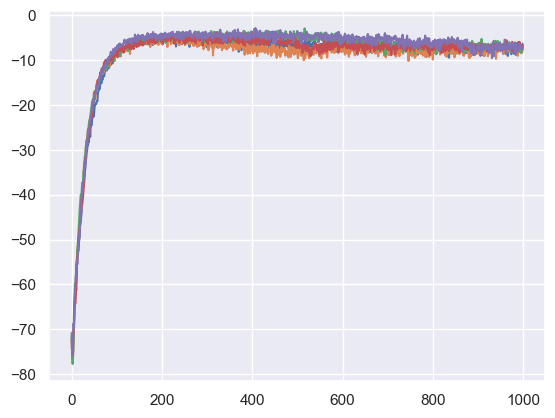

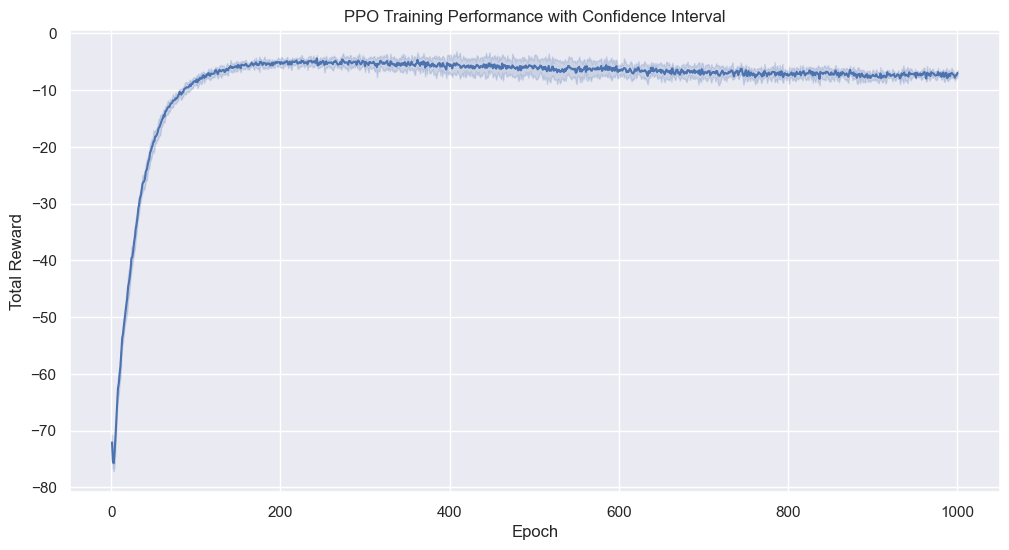

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rl_monitoring_utils.vectorized_env_wrapper import VectorizedEnvWrapper
from policies.diagonal_gaussian import DiagonalGaussianPolicy
from learning_utils.value_estimator import ValueEstimator
from agents.ppo import PPO
import gym

# Initialize environment and models
inverter_control = VectorizedEnvWrapper(gym.make("InverterControl-v0"), num_envs=8)

# Parameters
num_repeats = 5
epochs = 1000
gamma = 1
T = 720
kl_threshold = 1e-3

# Store total rewards for each run
all_rewards = []

for run in range(num_repeats):
    # Initialize new instances for each run
    # policy = CategoricalPolicy(inverter_control, lr = 1e-2)
    policy = DiagonalGaussianPolicy(inverter_control, lr = 1e-2, hidden_sizes=[64])
    value_estimator = ValueEstimator(inverter_control, lr=1e-2)
    agent, totals_ppo = PPO(inverter_control, policy, value_estimator, epochs=epochs, gamma=gamma, T=T, kl_threshold=kl_threshold)
    
    all_rewards.append(totals_ppo)

# Convert rewards to a DataFrame
all_rewards = np.array(all_rewards)
epochs_range = np.arange(1, epochs + 1)
df = pd.DataFrame(all_rewards.T, columns=[f"Run_{i+1}" for i in range(num_repeats)])
df['Epoch'] = epochs_range

# Melt the DataFrame for seaborn
df_melted_2 = df.melt(id_vars=['Epoch'], var_name='Run', value_name='Reward')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted_2, x='Epoch', y='Reward', ci="sd", estimator="mean")
plt.title("PPO Training Performance with Confidence Interval")
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.show()


C:\Users\mf36244\AppData\Local\Temp\ipykernel_31008\2702286229.py:44: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_melted_3, x='Epoch', y='Reward', ci="sd", estimator="mean")


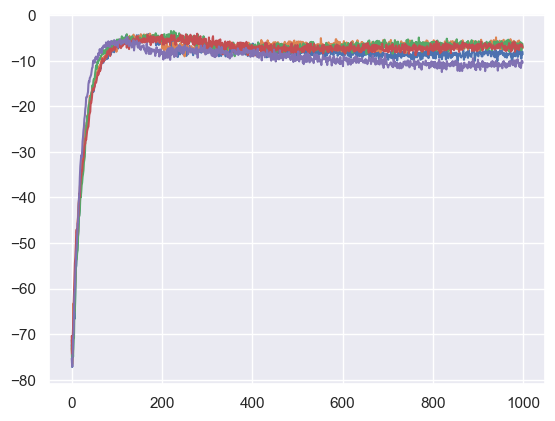

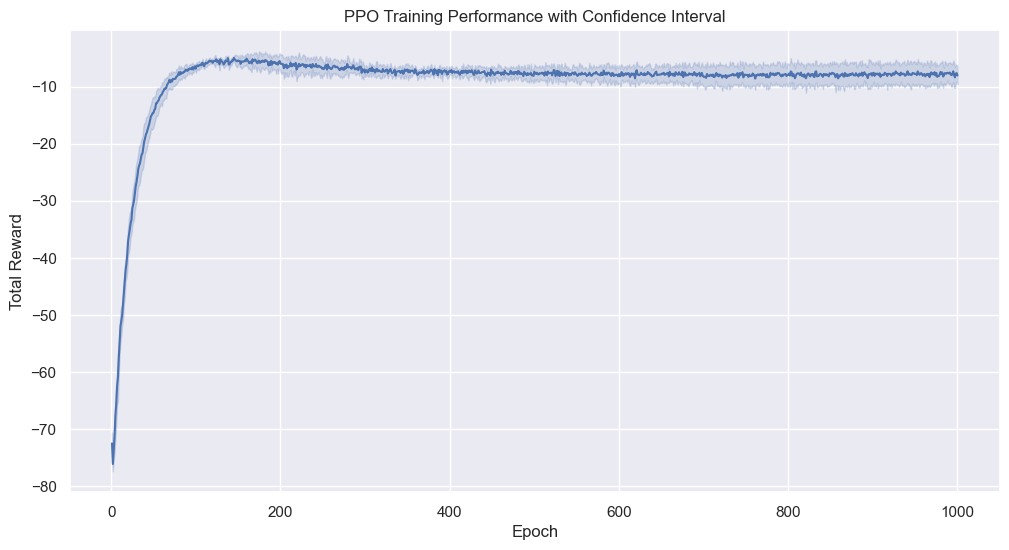

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rl_monitoring_utils.vectorized_env_wrapper import VectorizedEnvWrapper
from policies.diagonal_gaussian import DiagonalGaussianPolicy
from learning_utils.value_estimator import ValueEstimator
from agents.ppo import PPO
import gym

# Initialize environment and models
inverter_control = VectorizedEnvWrapper(gym.make("InverterControl-v0"), num_envs=8)

# Parameters
num_repeats = 5
epochs = 1000
gamma = 1
T = 720
kl_threshold = 1e-3

# Store total rewards for each run
all_rewards = []

for run in range(num_repeats):
    # Initialize new instances for each run
    # policy = CategoricalPolicy(inverter_control, lr = 1e-2)
    policy = DiagonalGaussianPolicy(inverter_control, lr = 1e-2, hidden_sizes=[64, 32])
    value_estimator = ValueEstimator(inverter_control, lr=1e-2)
    agent, totals_ppo = PPO(inverter_control, policy, value_estimator, epochs=epochs, gamma=gamma, T=T, kl_threshold=kl_threshold)
    
    all_rewards.append(totals_ppo)

# Convert rewards to a DataFrame
all_rewards = np.array(all_rewards)
epochs_range = np.arange(1, epochs + 1)
df = pd.DataFrame(all_rewards.T, columns=[f"Run_{i+1}" for i in range(num_repeats)])
df['Epoch'] = epochs_range

# Melt the DataFrame for seaborn
df_melted_3 = df.melt(id_vars=['Epoch'], var_name='Run', value_name='Reward')

# Plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_melted_3, x='Epoch', y='Reward', ci="sd", estimator="mean")
plt.title("PPO Training Performance with Confidence Interval")
plt.xlabel("Epoch")
plt.ylabel("Total Reward")
plt.show()


In [14]:
import pickle

# Prepare data necessary for plotting
plot_data = {
    "all_rewards": all_rewards,  # Total rewards from all runs
    "epochs_range": epochs_range  # Range of epochs
}

# Save to a pickle file
with open("continuous.pkl", "wb") as f:
    pickle.dump(plot_data, f)

print("Plot data has been saved to discrete.pkl.")


Plot data has been saved to discrete.pkl.


### Plot everything together 

C:\Users\mf36244\AppData\Local\Temp\ipykernel_31008\418761928.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_melted_1, x='Epoch', y='Scaled Reward', ci="sd", estimator="mean", label="No Hidden Layers")
C:\Users\mf36244\AppData\Local\Temp\ipykernel_31008\418761928.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_melted_2, x='Epoch', y='Scaled Reward', ci="sd", estimator="mean", label="1 Hidden Layer")
C:\Users\mf36244\AppData\Local\Temp\ipykernel_31008\418761928.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df_melted_3, x='Epoch', y='Scaled Reward', ci="sd", estimator="mean", label="2 Hidden Layers")


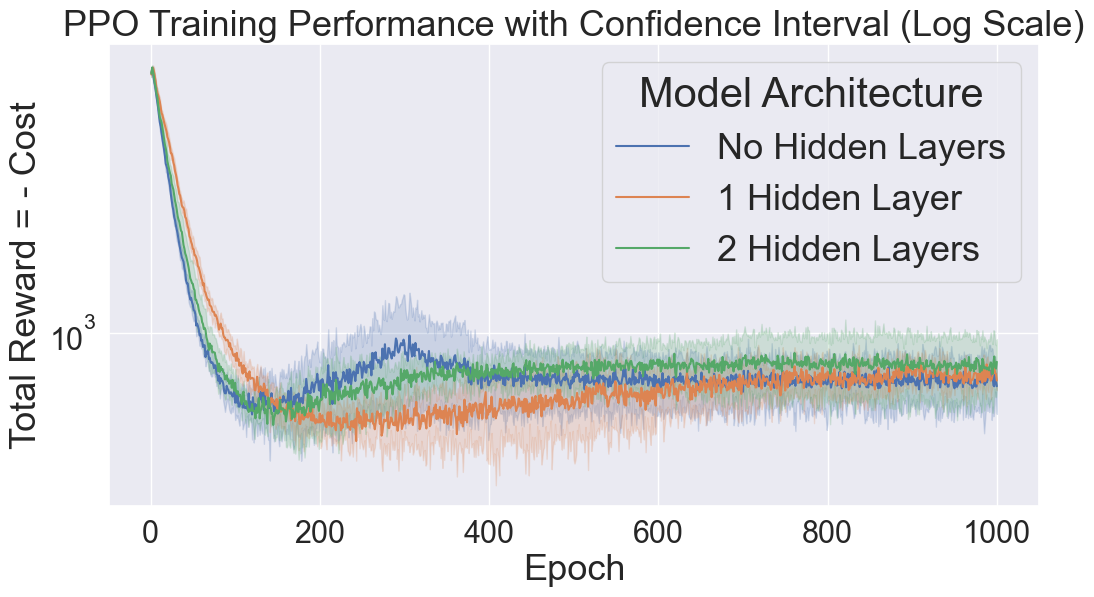

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_melted_1, df_melted_2, df_melted_3 are already loaded

# Scale the y-axis by 100 and create a new column in each dataframe for the scaled 'Reward'
df_melted_1['Scaled Reward'] = -df_melted_1['Reward'] * 100
df_melted_2['Scaled Reward'] = -df_melted_2['Reward'] * 100
df_melted_3['Scaled Reward'] = -df_melted_3['Reward'] * 100

# Set font size for all elements
plt.rcParams.update({'font.size': 26})

# Plot
plt.figure(figsize=(12, 6))

# Plot df_melted_1 (No hidden layers)
sns.lineplot(data=df_melted_1, x='Epoch', y='Scaled Reward', ci="sd", estimator="mean", label="No Hidden Layers")

# Plot df_melted_2 (1 hidden layer)
sns.lineplot(data=df_melted_2, x='Epoch', y='Scaled Reward', ci="sd", estimator="mean", label="1 Hidden Layer")

# Plot df_melted_3 (2 hidden layers)
sns.lineplot(data=df_melted_3, x='Epoch', y='Scaled Reward', ci="sd", estimator="mean", label="2 Hidden Layers")

# Set title and labels
plt.title("PPO Training Performance with Confidence Interval (Log Scale)", fontsize=26)
plt.xlabel("Epoch", fontsize=26)
plt.ylabel("Total Reward = - Cost", fontsize=26)

# Set y-axis to log scale
plt.yscale('log')

# Set the font size for axis tick labels (slightly smaller than labels)
plt.xticks(fontsize=22)  # Adjusted tick label size
plt.yticks(fontsize=22)  # Adjusted tick label size

# Show legend with enlarged title
plt.legend(title="Model Architecture", title_fontsize=30, fontsize=26)  # Enlarged legend title and font

# Show the plot
plt.show()
